## Generate the "observed" dataset

Here we will generate training, validation, and test sets that will be used as our "observed" dataset. These will consist of spectra generated using The Payne with noise added afterwards. These spectra are going to contain the entire line list, as opposed to the "synthetic" dataset, which will have particular lines masked out (ie. set to the continuum value).

In [1]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
%matplotlib inline 

import torch
from torch.autograd import Variable

import sys
sys.path.append('../')
from network import build_emulator

data_dir = '../data/'
emulator_fn = '../models/PAYNE.pth.tar'
data_file_obs = os.path.join(data_dir, 'csn_apogee.h5')

np.random.seed(1)

Build The Payne network

In [2]:
# Create emulator
(emulator, y_min, y_max) = build_emulator(model_fn=emulator_fn, 
                                          use_cuda=False)

Load the observed labels and error spectra that were used to train the domain transfer model.

In [3]:
datasets = ['train', 'val', 'test']

labels = []
spec_errs = []
with h5py.File(data_file_obs, 'r') as F:
    for dataset in datasets:
        labels.append(F['labels %s'%dataset][:])
        spec_errs.append(F['spectra_err %s'%dataset][:])

Generate the labels for our training, validation, and test sets. To do this, we will take the initial labels that were loaded above and use the Payne to generate spectra.

In [4]:
def predict_spectra(emulator, y, y_min, y_max):
    # Turn labels into pytorch variable
    y = Variable(torch.Tensor(y.astype(np.float32)))
    # Scale the labels the same as it was done during the training of the Payne
    scaled_labels = (y-y_min)/(y_max-y_min) - 0.5
    # Return predicted spectra
    return emulator(scaled_labels).data.numpy()

spectra = []
for y in labels:
    spectra.append(predict_spectra(emulator, y, y_min, y_max))

From these, we will add noise drawn from a distribution defined by *real* noise spectra.

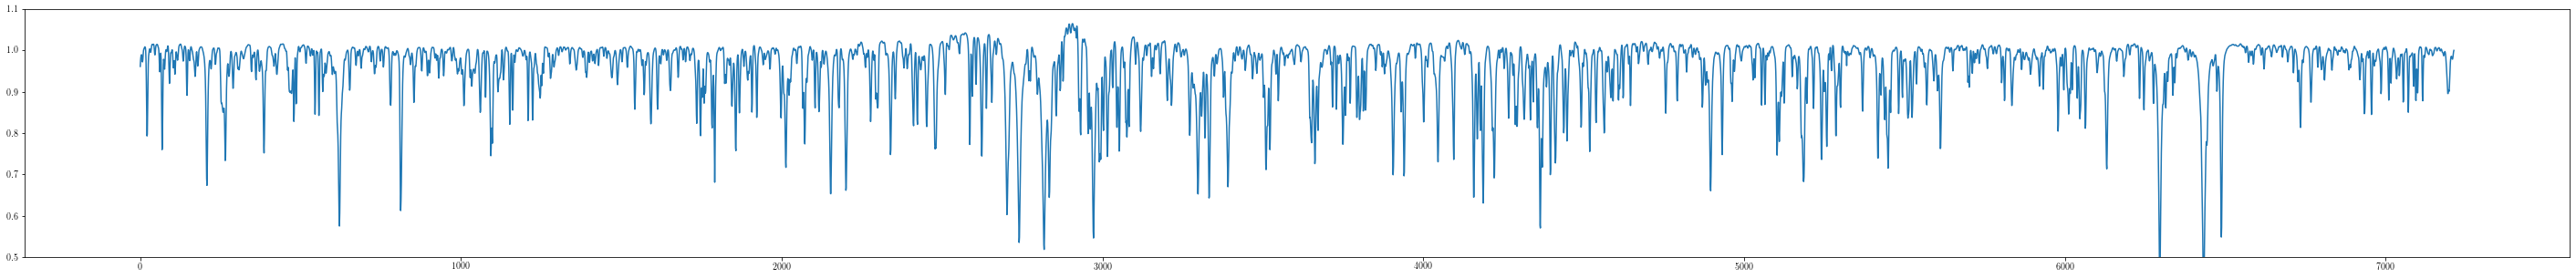

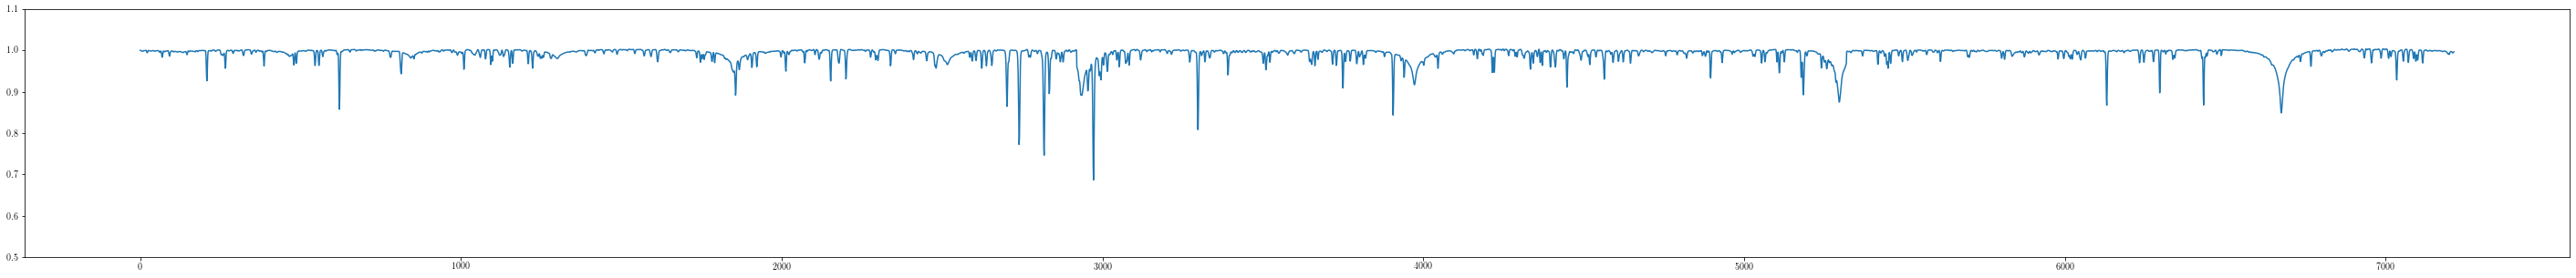

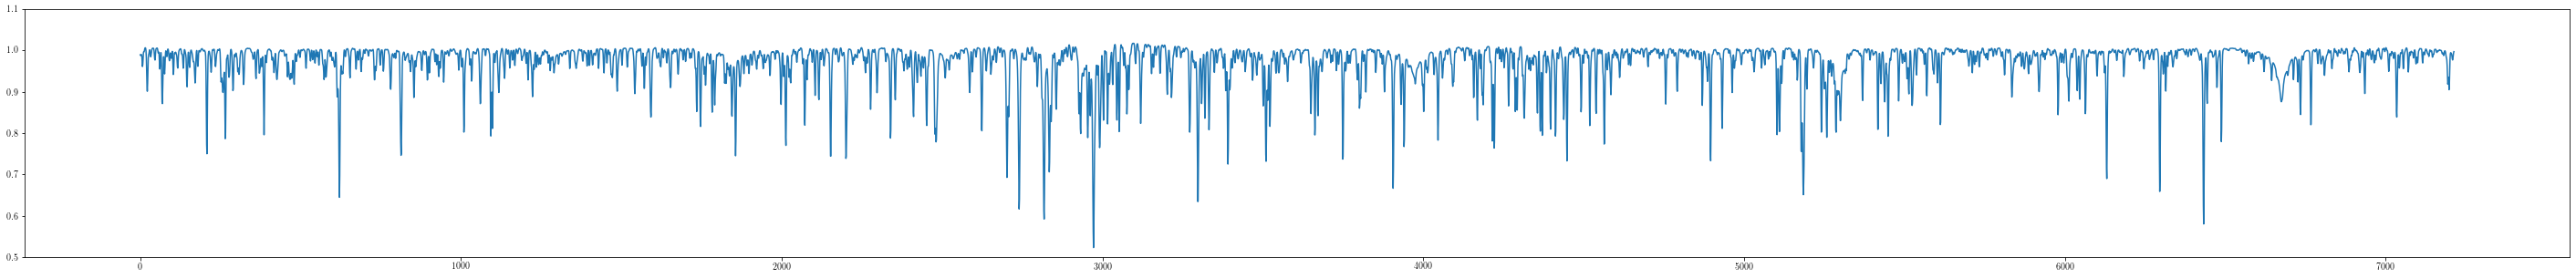

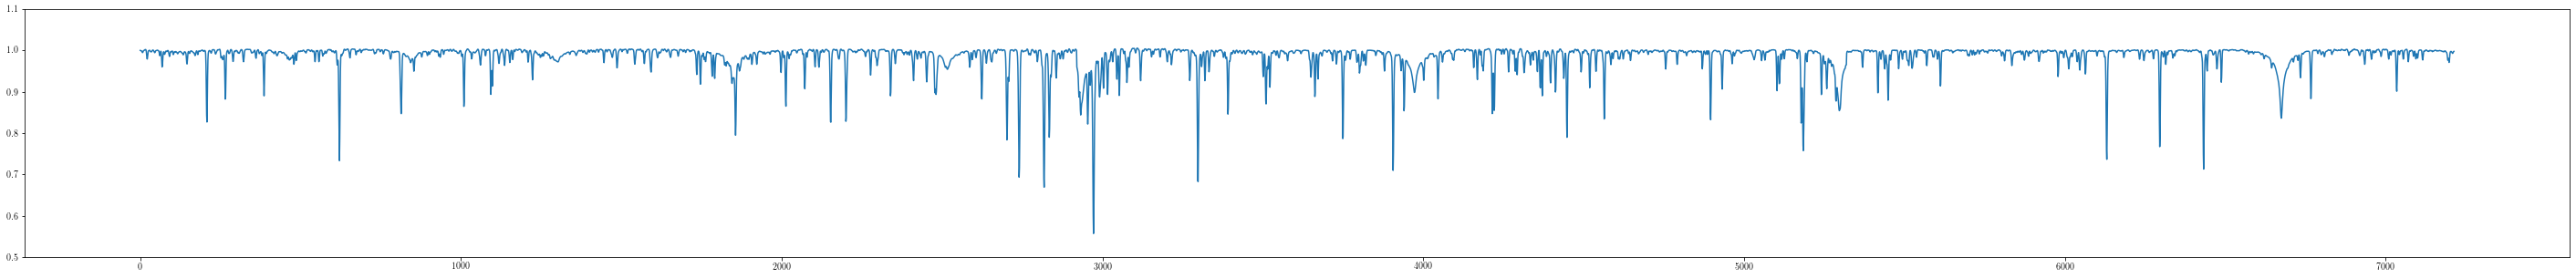

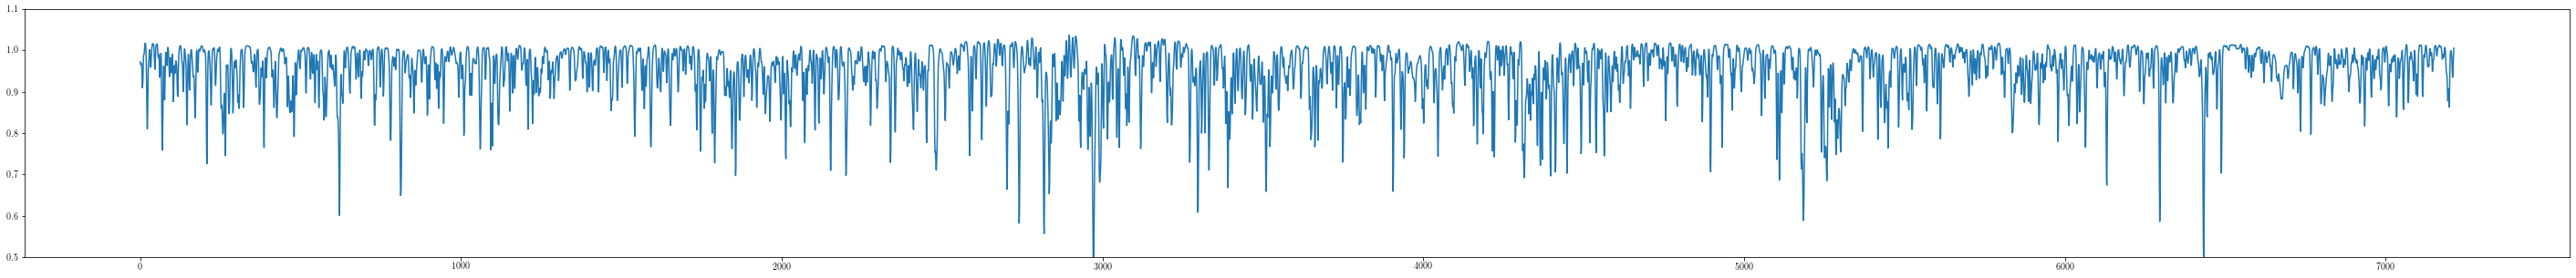

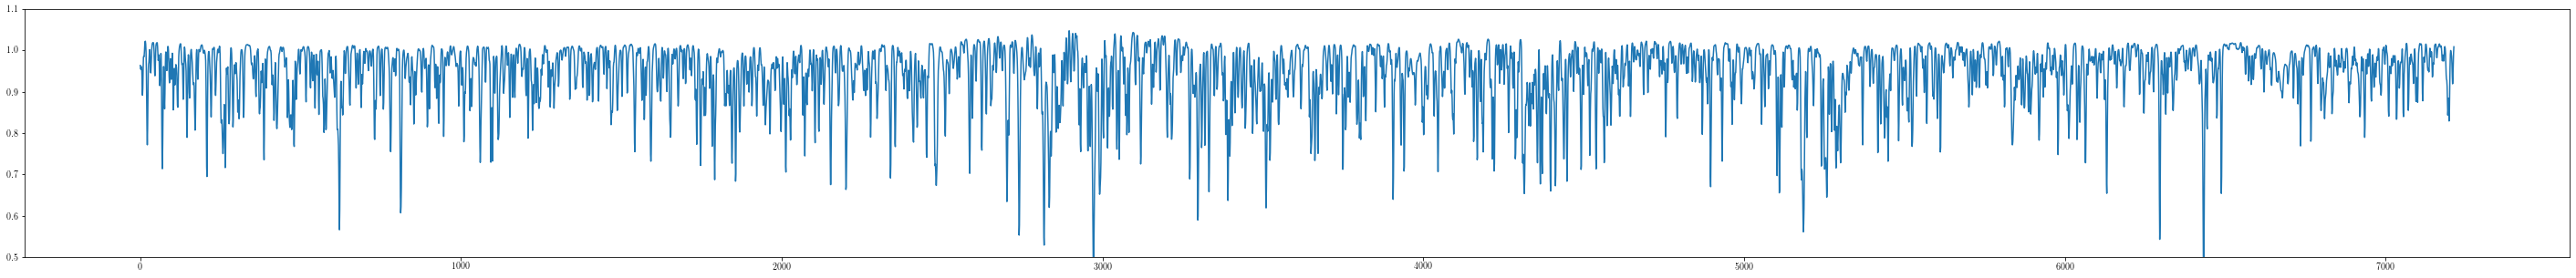

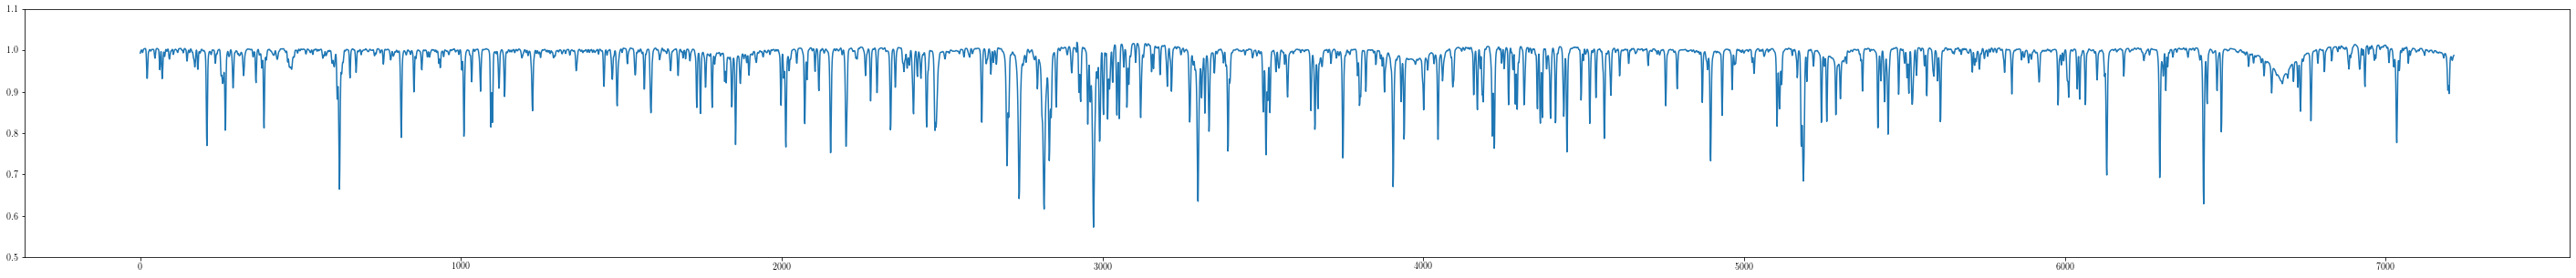

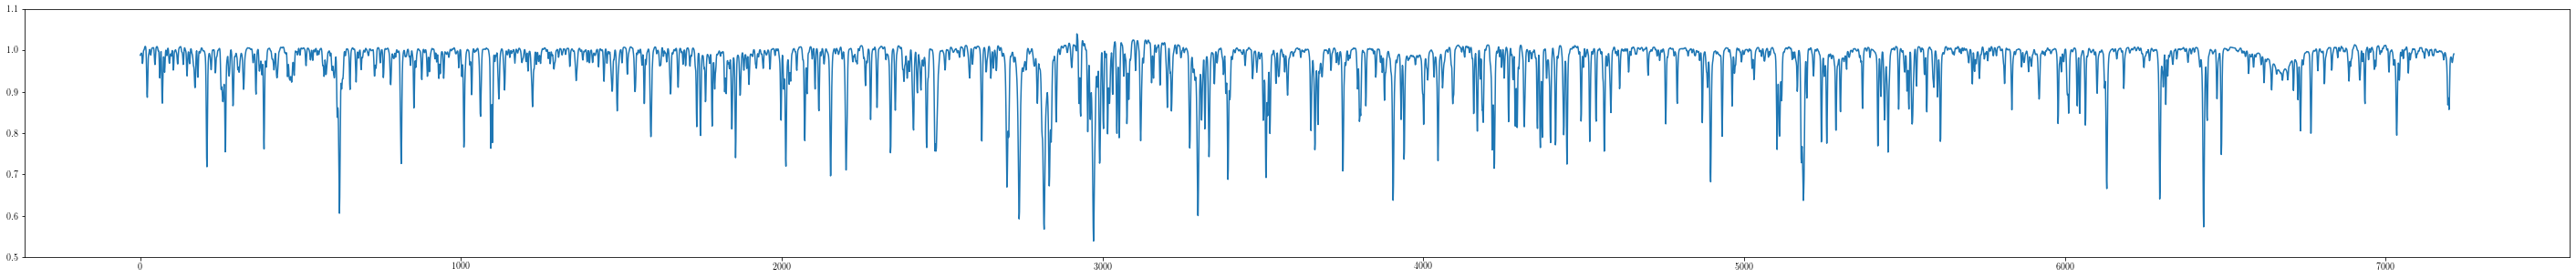

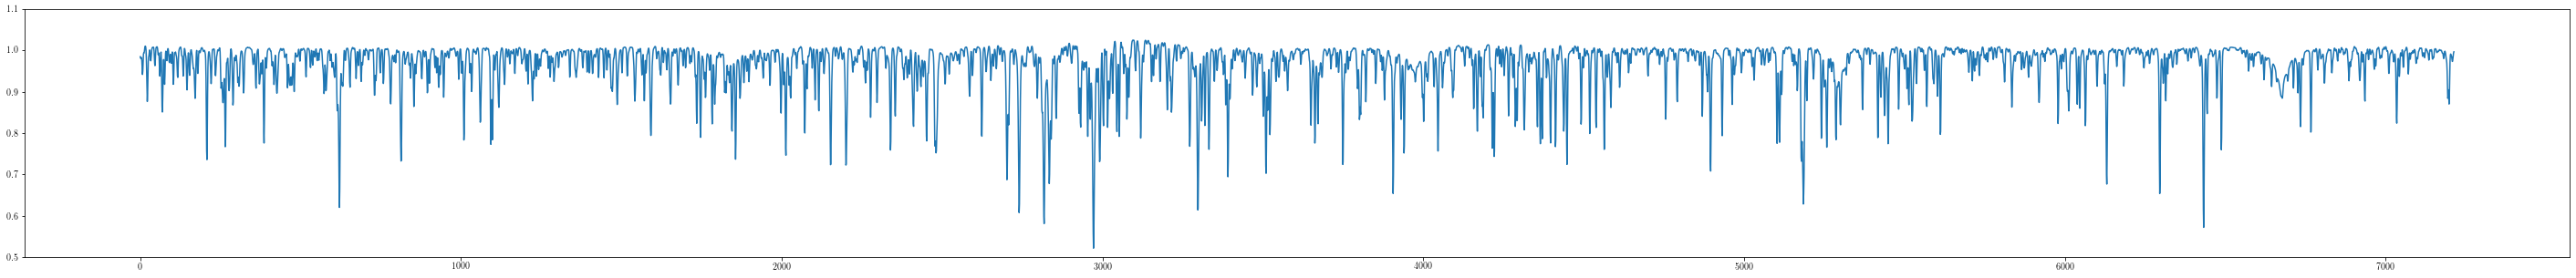

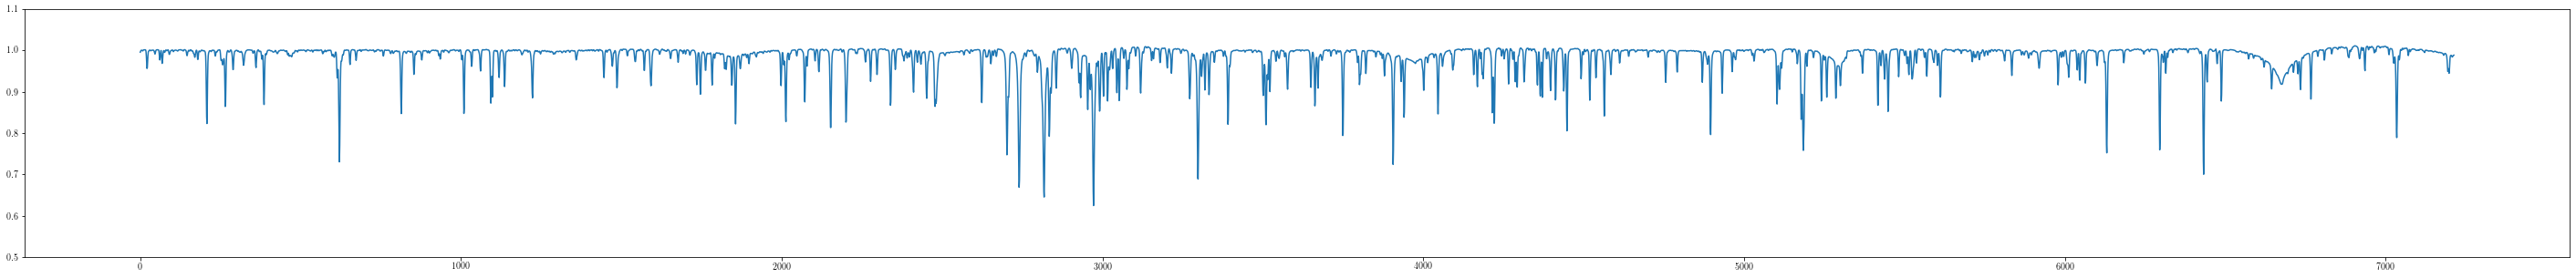

In [5]:
for i in range(10):
    plt.figure(figsize=(50,5))
    plt.plot(spectra[0][i])
    plt.ylim(0.5, 1.1)
    plt.show()

In [6]:
snrs = []
for i in range(len(spectra)):
    # Don't include huge errors in noise generation
    x_err = np.clip(spec_errs[i],0,1)
    
    # Create noise
    noise = x_err*np.random.normal(size=x_err.shape)
    
    snrs.append(np.median(np.abs(spectra[i]/noise), 1))
    
    # Add noise to spectra
    spectra[i] += noise

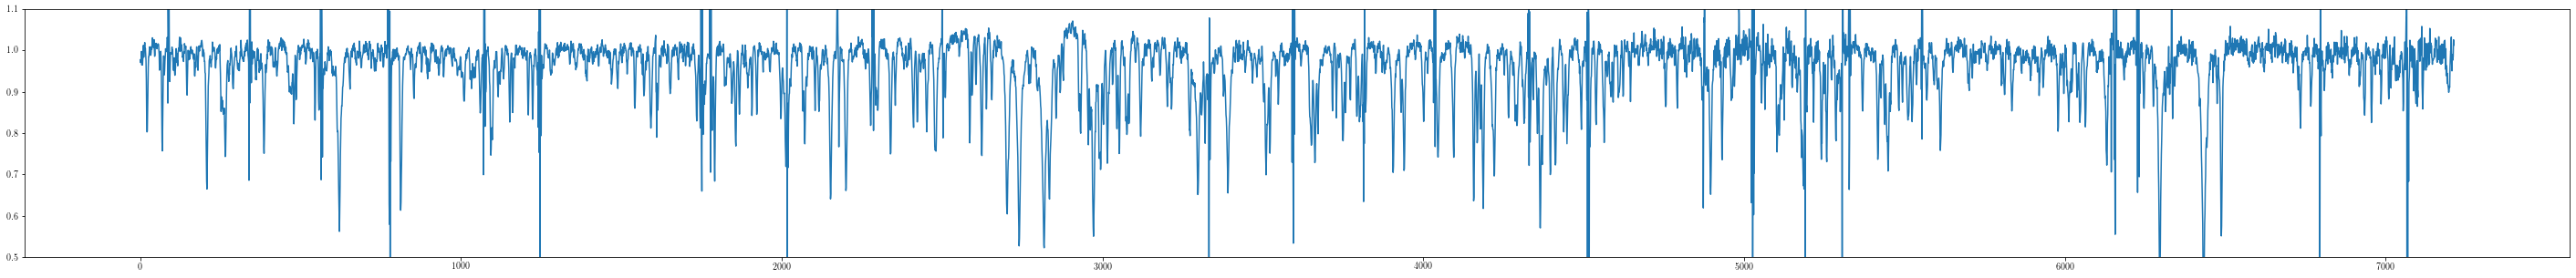

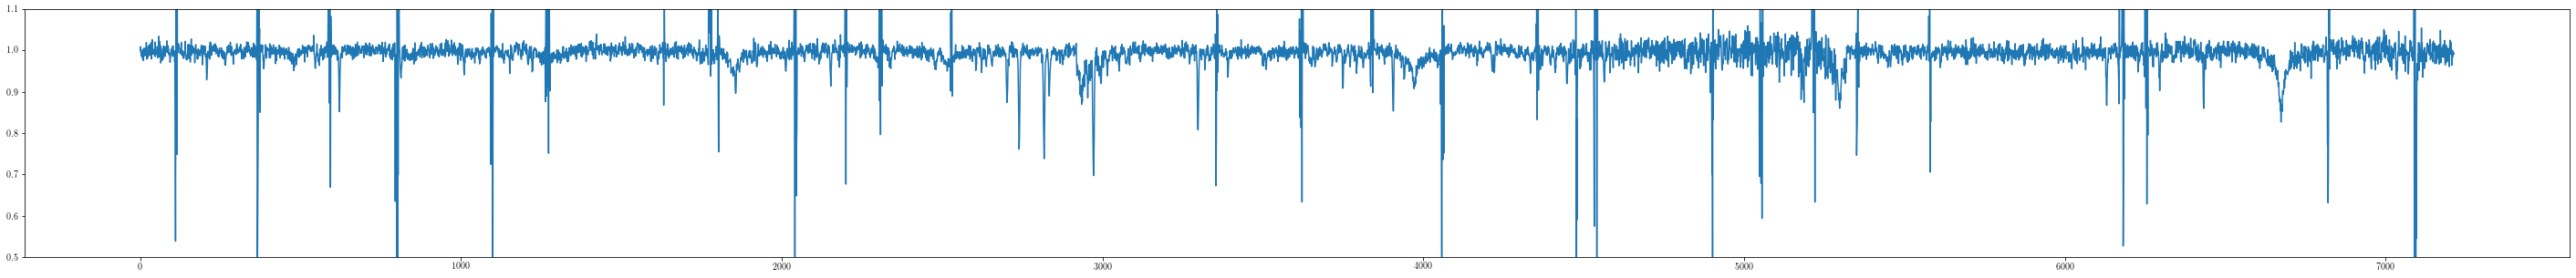

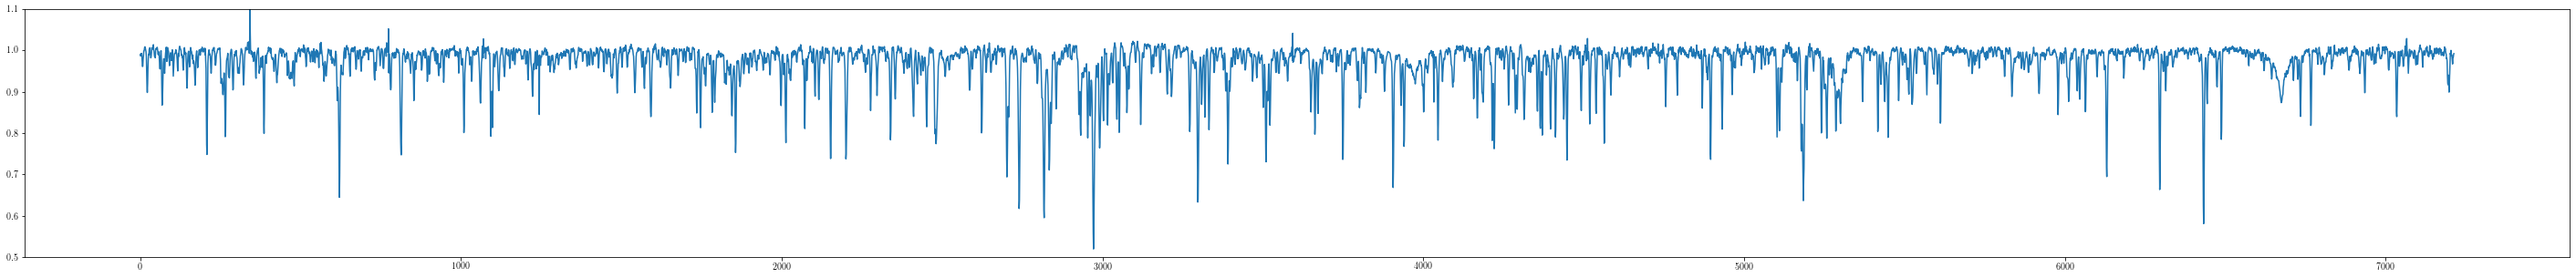

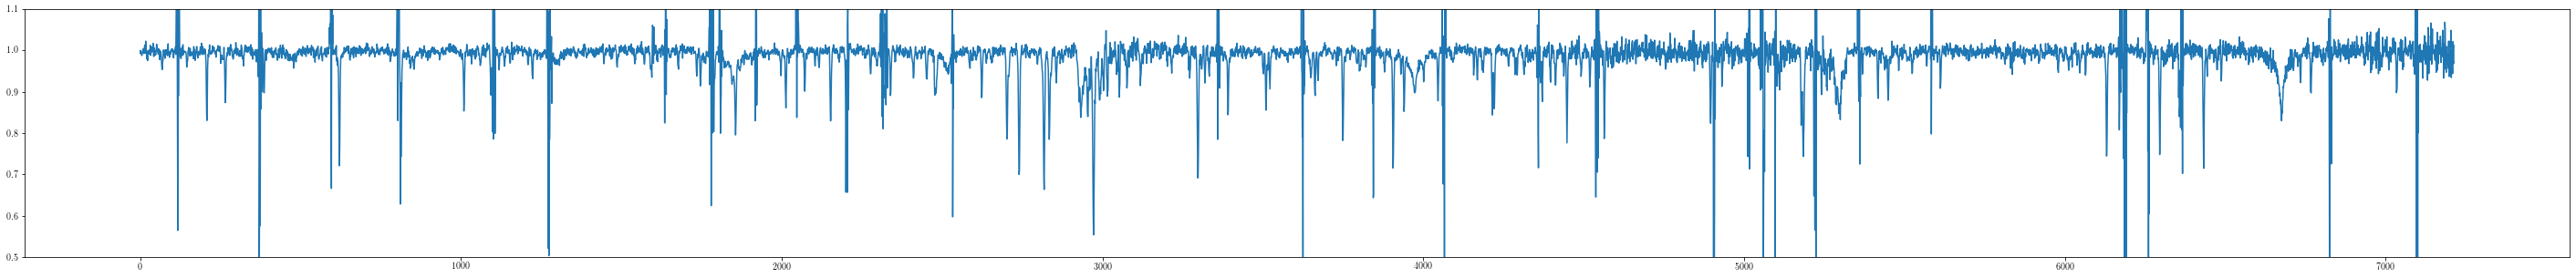

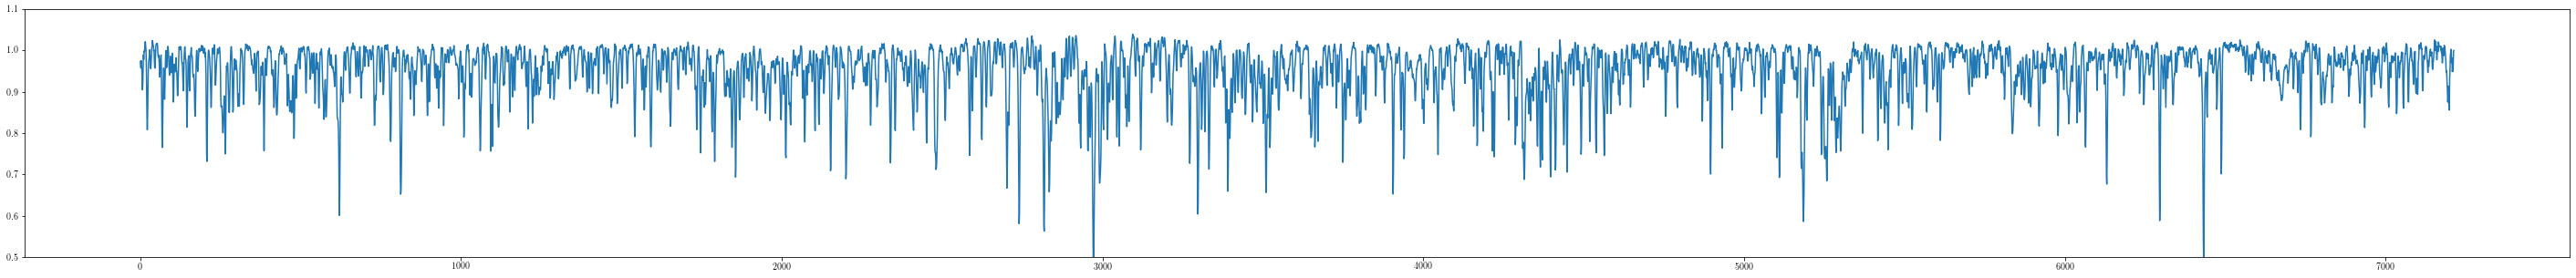

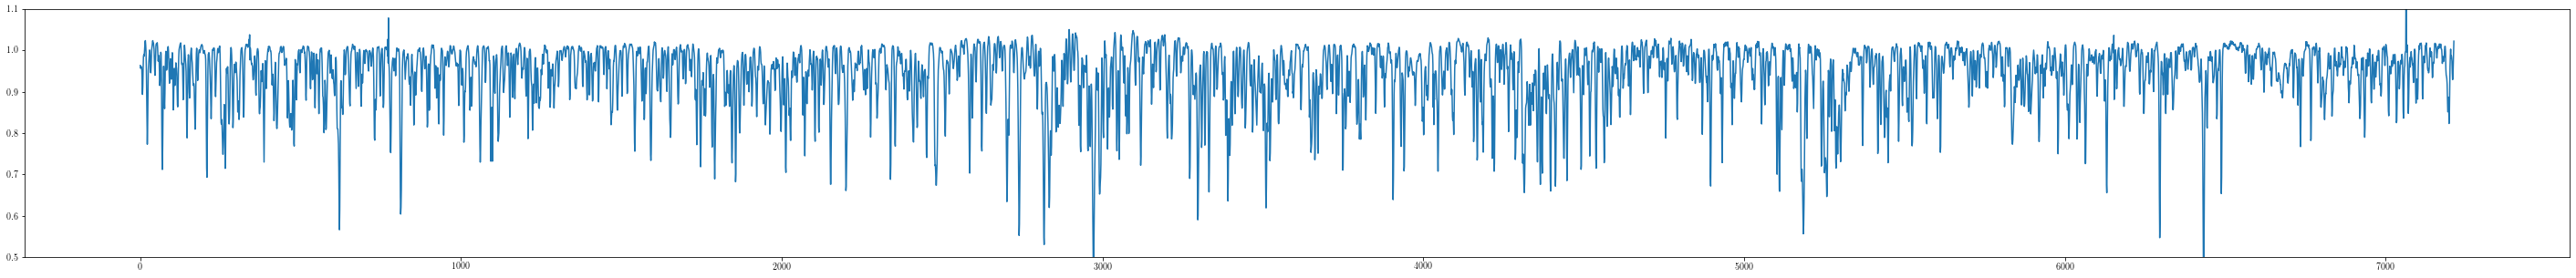

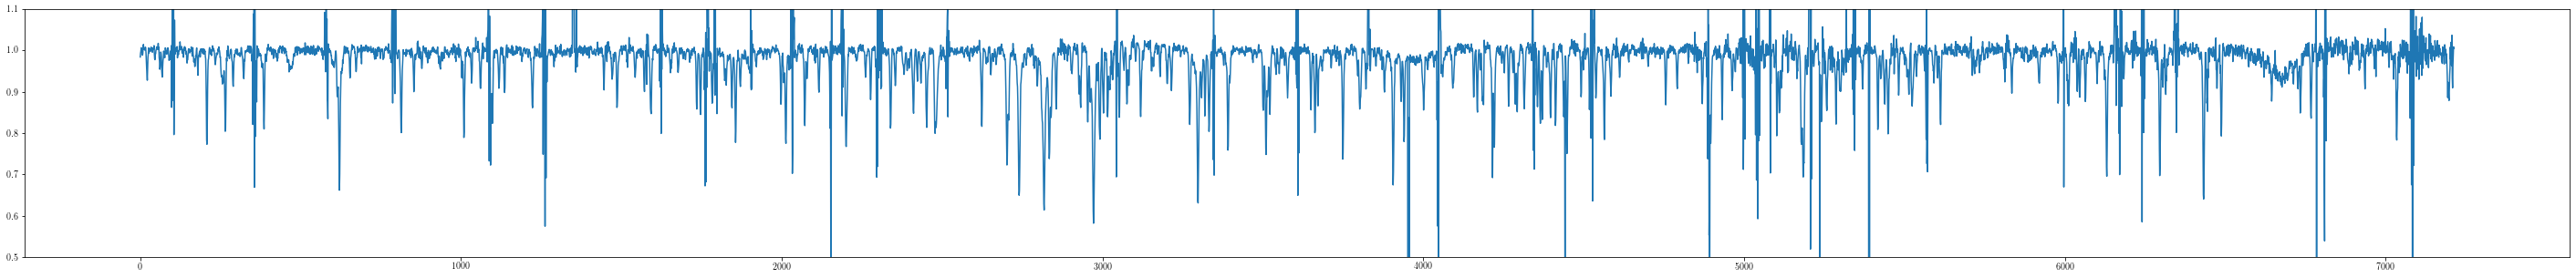

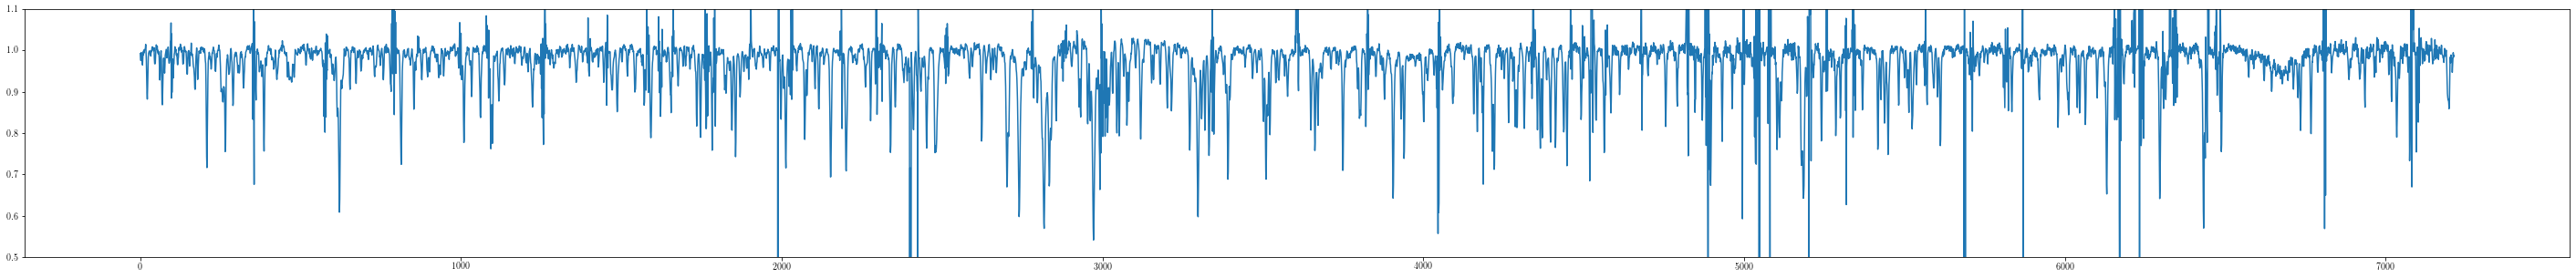

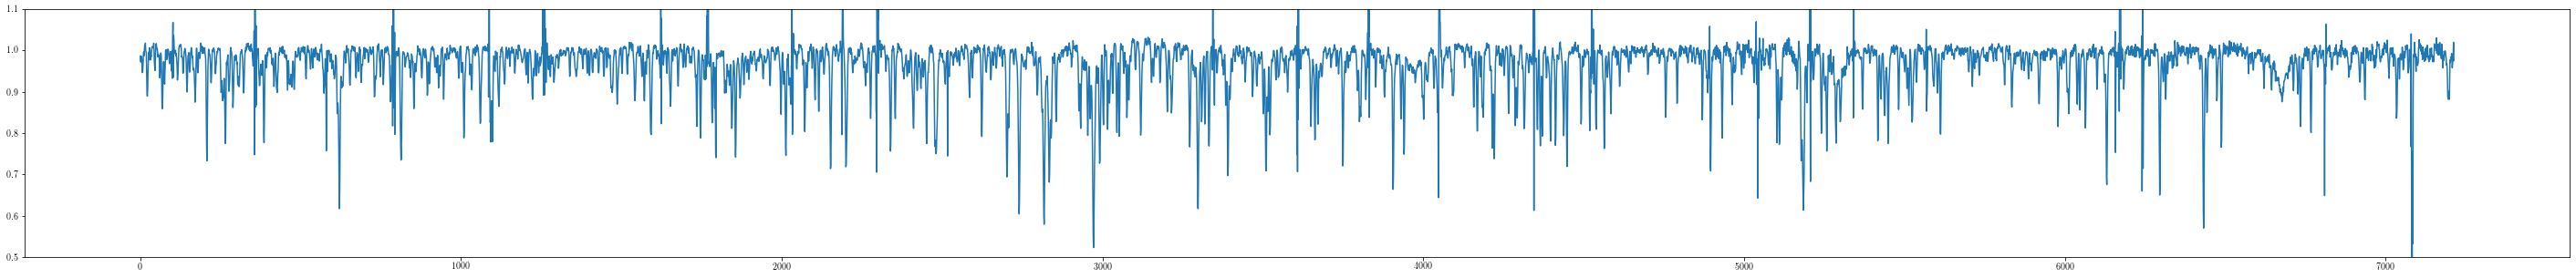

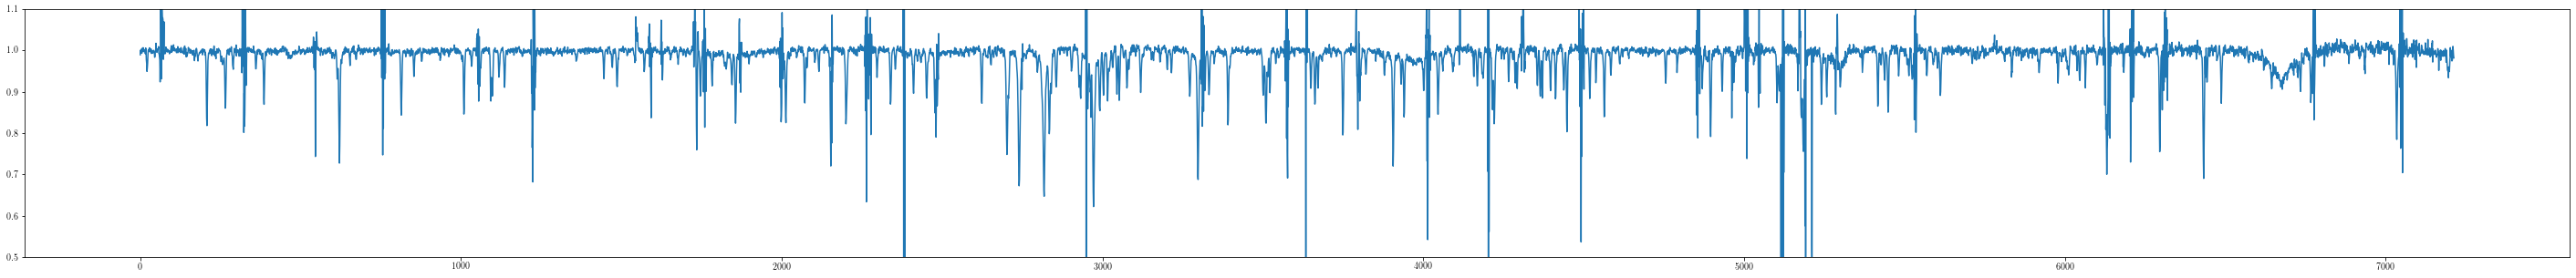

In [7]:
for i in range(10):
    plt.figure(figsize=(50,5))
    plt.plot(spectra[0][i])
    plt.ylim(0.5, 1.1)
    plt.show()

To give an idea of the approximate S/N limits, we will calculate the S/N for the cross-validation set.

In [8]:
print('The S/N of our observed dataset ranges from approximately %0.0f to %0.0f.' % (np.min(snrs[0]), np.max(snrs[0])))

The S/N of our observed dataset ranges from approximately 35 to 861.


Save data to an hdf5 file.

In [9]:
savename_synth = data_dir+'csn_apogee_mock.h5'

with h5py.File(savename_synth, "w") as f:    
    
    # Datasets for h5 file
    spec_tr_ds = f.create_dataset('spectra train', 
                                  spectra[0].shape, dtype="f")
    spec_val_ds = f.create_dataset('spectra val', 
                                  spectra[1].shape, dtype="f")
    spec_te_ds = f.create_dataset('spectra test', 
                                  spectra[2].shape, dtype="f")
    spec_err_tr_ds = f.create_dataset('spectra_err train', 
                                  spec_errs[0].shape, dtype="f")
    spec_err_val_ds = f.create_dataset('spectra_err val', 
                                  spec_errs[1].shape, dtype="f")
    spec_err_te_ds = f.create_dataset('spectra_err test', 
                                  spec_errs[2].shape, dtype="f")
    labels_tr_ds = f.create_dataset('labels train', 
                                  labels[0].shape, dtype="f")
    labels_val_ds = f.create_dataset('labels val', 
                                  labels[1].shape, dtype="f")
    labels_te_ds = f.create_dataset('labels test', 
                                  labels[2].shape, dtype="f")
    snr_tr_ds = f.create_dataset('snr train', 
                                  snrs[0].shape, dtype="f")
    snr_val_ds = f.create_dataset('snr val', 
                                  snrs[1].shape, dtype="f")
    snr_te_ds = f.create_dataset('snr test', 
                                  snrs[2].shape, dtype="f")
    
    # Save data
    spec_tr_ds[:] = spectra[0]
    spec_val_ds[:] = spectra[1]
    spec_te_ds[:] = spectra[2]
    spec_err_tr_ds[:] = spec_errs[0]
    spec_err_val_ds[:] = spec_errs[1]
    spec_err_te_ds[:] = spec_errs[2]
    labels_tr_ds[:] = labels[0]
    labels_val_ds[:] = labels[1]
    labels_te_ds[:] = labels[2]
    snr_tr_ds[:] = snrs[0]
    snr_val_ds[:] = snrs[1]
    snr_te_ds[:] = snrs[2]
            
print('finished.')

finished.


Lastly, collect the mean and standard deviation of the synthetic spectra for normalizing the inputs to the Cycle-GAN.

In [9]:
spectra_payne = np.load(data_dir+'mock_all_spectra_no_noise_resample_prior_large.npz')['spectra']
np.save(data_dir+'mean_and_std_PAYNE_specs.npy', np.array([np.mean(spectra_payne),np.std(spectra_payne)]))